In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
purchases = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';', index_col=0)

In [3]:
purchases.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [4]:
purchases.shape[0] == purchases.uid.nunique()

True

In [5]:
# Проверка распределения значений purchase по экспериментальным группам

print('purchases.purchase destribution:')
pd.concat([purchases.query('experimentVariant == 0').purchase.value_counts().rename('expVar = 0'), \
           purchases.query('experimentVariant == 1').purchase.value_counts().rename('expVar = 1')], axis=1)

purchases.purchase destribution:


,expVar = 0,expVar = 1
0,61591,60513
1,1511,3403


In [6]:
# Проверка распределения пользователей разных версий по экспериментальным группам

print('purchases.version destribution:')
pd.concat([purchases.query('experimentVariant == 0').version.value_counts().rename('expVar = 0'), \
           purchases.query('experimentVariant == 1').version.value_counts().rename('expVar = 1')], axis=1)

purchases.version destribution:


,expVar = 0,expVar = 1
v2.8.0,41283,41552
v2.9.0,11921,12033
v3.8.0.0,5694,6110
v3.7.4.0,4204,4221


In [7]:
# Датафрейм со сравниваемыми группами

df = pd.DataFrame({
    "A1": purchases.query('experimentVariant == 1').reset_index().purchase,
    "A2": purchases.query('experimentVariant == 0').reset_index().purchase
})

In [8]:
df.isnull().sum()

A1      0
A2    814
dtype: int64

In [9]:
# Проводим А/А тест

simulations = 1000
n_s = 1000
res = []

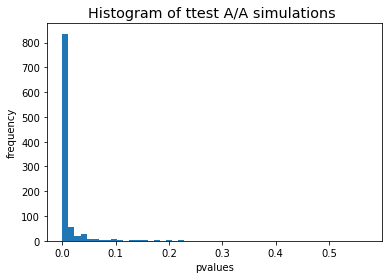

FPR: 0.944


In [10]:
# Запуск симуляций A/A теста

for i in tqdm(range(simulations)):
    s1 = df['A1'].sample(n_s, replace = False).values
    s2 = df['A2'].dropna().sample(n_s, replace = False).values

    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('FPR:', sum(np.array(res) < 0.05) / simulations)

In [11]:
# В большинстве тестов обнаружена стат значимая разница между выборками
# Ищем проблему

checking_df = purchases.groupby(['version', 'experimentVariant']).agg({'purchase': 'sum', 'uid': 'count'})
checking_df['ratio * 1000'] = checking_df.purchase / checking_df.uid * 1000

In [12]:
checking_df

purchase    uid  ratio * 1000
version  experimentVariant                               
v2.8.0   0                        41  41283      0.993145
         1                      1895  41552     45.605506
v2.9.0   0                       890  11921     74.658166
         1                       858  12033     71.303914
v3.7.4.0 0                       252   4204     59.942912
         1                       266   4221     63.018242
v3.8.0.0 0                       328   5694     57.604496
         1                       384   6110     62.847791

In [13]:
# В случае версии 'v2.8.0' количество пользователей примерно однинаково для обеих экспериментальных групп
# Однако значение показателя целевой метрики (purchase) для обеих групп очень сильно различается

s1 = purchases.query('version == "v2.8.0"').query('experimentVariant==1').reset_index().purchase
s2 = purchases.query('version == "v2.8.0"').query('experimentVariant==0').reset_index().purchase

stats.ttest_ind(s1, s2, equal_var = False)

Ttest_indResult(statistic=43.097051598551076, pvalue=0.0)

In [14]:
# Проверим остальные версии приложения

s1 = purchases.query('version == "v2.9.0" & experimentVariant==1').reset_index().purchase
s2 = purchases.query('version == "v2.9.0" & experimentVariant==0').reset_index().purchase

stats.ttest_ind(s1, s2, equal_var = False)

Ttest_indResult(statistic=-0.997860971925487, pvalue=0.31835686930247525)

In [15]:
s1 = purchases.query('version == "v3.7.4.0"').query('experimentVariant==1').reset_index().purchase
s2 = purchases.query('version == "v3.7.4.0"').query('experimentVariant==0').reset_index().purchase

stats.ttest_ind(s1, s2, equal_var = False)

Ttest_indResult(statistic=0.5875202960070302, pvalue=0.5568700784122844)

In [16]:
s1 = purchases.query('version == "v3.8.0.0"').query('experimentVariant==1').reset_index().purchase
s2 = purchases.query('version == "v3.8.0.0"').query('experimentVariant==0').reset_index().purchase

stats.ttest_ind(s1, s2, equal_var = False)

Ttest_indResult(statistic=1.1973368830477649, pvalue=0.2311993431794881)

In [17]:
# Создаём новый датафрейм без версии 2.8.0 

purchases_final = purchases.query('version != "v2.8.0"')

In [19]:
checking_final = purchases_final.groupby(['version', 'experimentVariant']).agg({'purchase': 'sum', 'uid': 'count'})
checking_final['ratio * 1000'] = checking_final.purchase / checking_final.uid * 1000

In [20]:
checking_final

purchase    uid  ratio * 1000
version  experimentVariant                               
v2.9.0   0                       890  11921     74.658166
         1                       858  12033     71.303914
v3.7.4.0 0                       252   4204     59.942912
         1                       266   4221     63.018242
v3.8.0.0 0                       328   5694     57.604496
         1                       384   6110     62.847791

In [21]:
df_final = pd.DataFrame({
    "A1": purchases_final.query('experimentVariant == 1').reset_index().purchase,
    "A2": purchases_final.query('experimentVariant == 0').reset_index().purchase
})

In [22]:
df.isnull().sum()

A1      0
A2    814
dtype: int64

In [24]:
# Обновляем res

res = []

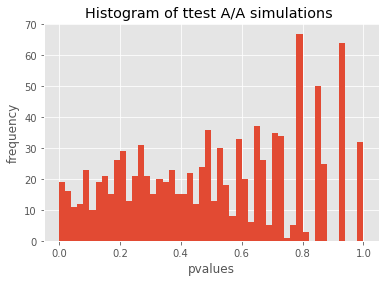

FPR: 0.042


In [25]:
# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_final['A1'].sample(n_s, replace = False).values
    s2 = df_final['A2'].dropna().sample(n_s, replace = False).values

    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('FPR:', sum(np.array(res) < 0.05) / simulations)

### Выводы:
* В результате проделанной работы было проведено А/А тестирование мобильного приложения
* В ходе теста была выявлена пробелма в работе сплиттера  
(распределение p-value оказалось сильно смещено влево, а FPR > 0.05, т.е. большинство выборок статистически различались)
    
    
* Был проведён дальнейший анализ данных с целью поиска проблемы
* Была обнаружена (и с помощью t-test'а доказана) некорректная работа сплиттера с пользователями приложения версии 'v2.8.0'
* После удаления дисбалансных данных и повторения А/А теста получили адекватное распределение  
выборочных p-value, а также FPR < 0.05


#### В конечном итоге можно сказать, что сплиттер работает корректно со всеми версиями приложения, кроме v2.8.0, разработчикам сплит-алгоритма необходимо обратить внимание на данную версию приложения